## all current generators and readouts


## setup

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

In [3]:
# use pyro's traceback code instead of ipython's (optional)
# adapted from https://pyro4.readthedocs.io/en/stable/errors.html and https://stackoverflow.com/a/70433500
import IPython
import Pyro4.util
import sys

from IPython import get_ipython
ip = get_ipython()

def exception_handler(self, etype, evalue, tb, tb_offset=None):
    sys.stderr.write("".join(Pyro4.util.getPyroTraceback()))
    # self.showtraceback((etype, evalue, tb), tb_offset=tb_offset)  # standard IPython's printout

ip.set_custom_exc((Exception,), exception_handler)  # register your handler

## firmware
This demo is using the firmware in https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2024-05-29_216_tprocv2r20_q3diamond/.
This is a ZCU216 firmware.
The firmware project is https://github.com/awsch/qick-spin/blob/main/firmware/proj_216_q3diamond.tcl (and uses the IP versions in that repo, specifically core revision 20 of the tProc v2).

This firmware is sort of similar to the old "q3diamond" firmware, in that it has a lot of different generators and readouts. The mux gen and mux readout are new versions; the old versions are still available for use if you want them in your firmware, and both tProc v1 and v2 support all generators and readouts.
* one standard full-speed generator (axis_signal_gen_v6)
* two interpolated generators (axis_sg_int4_v1)
* two different muxed generators
    * axis_sg_mux4_v2 - this is the one we've had for a long time now
    * axis_sg_mux8_v1 - this is a new one:
        * it can play up to 8 tones
        * full phase coherence
        * you can set the tone phases
        * it doesn't use the digital mixer, so the DAC can have a sampling frequency up to 10 Gsps; the bad news is that this uses way more FPGA resources and this generator won't fit on the FPGA if you want a lot of other generators as well
            * we plan to make a generator that uses the digital mixer, but otherwise gets the nice features of mux8_v1 (8 tones, full phase coherence, phase control) - this should work for almost everyone, and it will fit better on the FPGA?
* one standard readout (axis_readout_v2)
* one tProc-configured readout (axis_readout_v3)
* one muxed readout (axis_pfb_readout_v3) - this is a new one:
    * finer channel spacing, the ADC Nyquist zone is divided into 64 slices instead of 8
    * full phase coherence
    * the ability to take two outputs from a single channel (you will still see lots of crosstalk if you play two tones simultaneously in the same channel; you'll get a warning if your readout frequencies put you at danger of this)
    * you can set the downconversion phase (this is also possible on the standard and tProc-configured readouts)
    * there's a version (axis_pfb_readout_v4) with 8 outputs instead of 4, otherwise identical

Some general comments (not specific to tProc v2):
* You can always mix and match generators and readouts to suit your RF setup and experimental needs. This demo matches them up in a certain arbitrary way, but this is not the law.
* "Full phase coherence" is my new shorthand for "phase-coherent with respect to frequency changes."
    * All QICK generators and readouts are phase-coherent in the sense that if you play (or downconvert) a pulse, wait a while, and repeat, the carrier LO will maintain its phase just as if it had been running continuously. In terms of qubit control, this means that the carrier phase will track the qubit phase, and your X-gate will always be an X-gate.
    * Some generators and readouts (for example, the standard generator and readout) are fully phase-coherent: if you change the carrier frequency the phase will change in a predictable way, and when you change the frequency back, the phase will go back just as if you had never changed the frequency. This allows you to do frequency scans and get meaningful phase information.
    * Some generators and readouts (for example, the old muxed generator and readout - mux4_v2 and pfb_readout_v2), and the digital mixer, are not fully phase-coherent. These are phase-continuous: if you change the frequency, the phase doesn't jump. But that is not a useful property for us. These are OK for qubit readout once you know what frequencies to use, but you will probably want to do your resonator spectroscopy with a different channel or firmware where you have full phase coherence.

I've set things up with three loopbacks, approximately as shown:
* DAC 2_230 to ADC 2_226, 10MHz-1GHz baluns
* DAC 0_231 to ADC 0_226, 10MHz-1GHz baluns
* DAC 0_230 to ADC 1_226, 1-4 GHz baluns, with an unterminated SMA tee with three barrels (to act as a resonator) - note that this isn't what's shown in the photo (which is old), I changed baluns, removed the filter, and added two more barrels than are in the photo because I wanted to go to a lower frequency.

![image.png](01_gens-and-readouts_photo.jpg)

In [4]:
from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="pynq216.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_1d6731afd1764ea5b87d53980f7ce3af@131.225.86.222:39233

QICK configuration:

	Board: ZCU216

	Software version: 0.2.265
	Firmware timestamp: Wed May 29 14:35:58 2024

	Global clocks (MHz): tProcessor 614.400, RF reference 245.760

	5 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_sg_mux8_v1 - envelope memory 0 samples (0.000 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 16-bit DDS, range=1720.320 MHz
		DAC tile 3, blk 0 is 0_231, on JHC3
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 16-bit DDS, range=1720.320 MHz
		DAC tile 3, blk 1 is 1_231, o

### Muxed generator and muxed readout
Since we only have 4 outputs on the mux readout in this firmware, we'll only play 4 tones on the mux generator. But you could play 8 tones.

Note that more channels on the mux readout means less bandwidth per channel, and a correspondingly lower sample rate on the decimated data.

  0%|          | 0/1 [00:00<?, ?it/s]

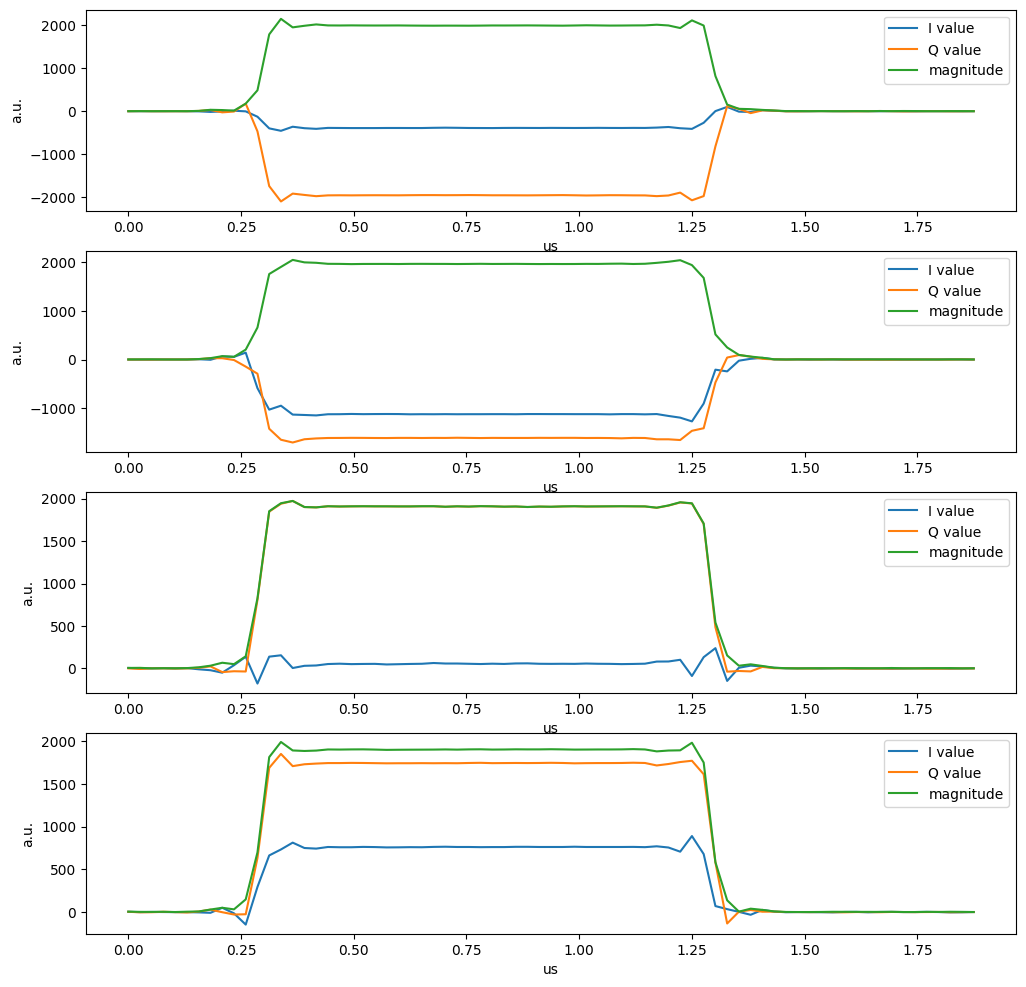

In [5]:
class MuxProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'])
        # self.declare_gen(ch=gen_ch, ro_ch=ro_chs[0], mux_freqs=cfg['freqs'], mux_gains=cfg['gains'], mixer_freq=0)
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3],
                      )
        
    def body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': 1,
          'ro_chs': [2,3,4,5],
          'pulse_freqs': [500, 550, 600, 650],
          'pulse_gains': [1.0]*4,
          'pulse_phases': [0.0]*4,
          'ro_phases': [0.0]*4,
          'trig_time': 0.4,
          'pulse_len': 1.0,
          'ro_len': 1.9,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

We can calculate the phases we're seeing in the data, and use that to rotate the data onto the positive real axis. We can apply the phase correction in two ways: we can subtract it from the upconversion phase, or add it to the downconversion phase.

In [6]:
phases = [np.angle(iq.mean(axis=0).dot([1,1j]), deg=True) for iq in iq_list]
print("phase offsets:", phases)

phase offsets: [-101.11103329813758, -125.0709655233826, 88.23645300668836, 66.59548170150518]


  0%|          | 0/1 [00:00<?, ?it/s]

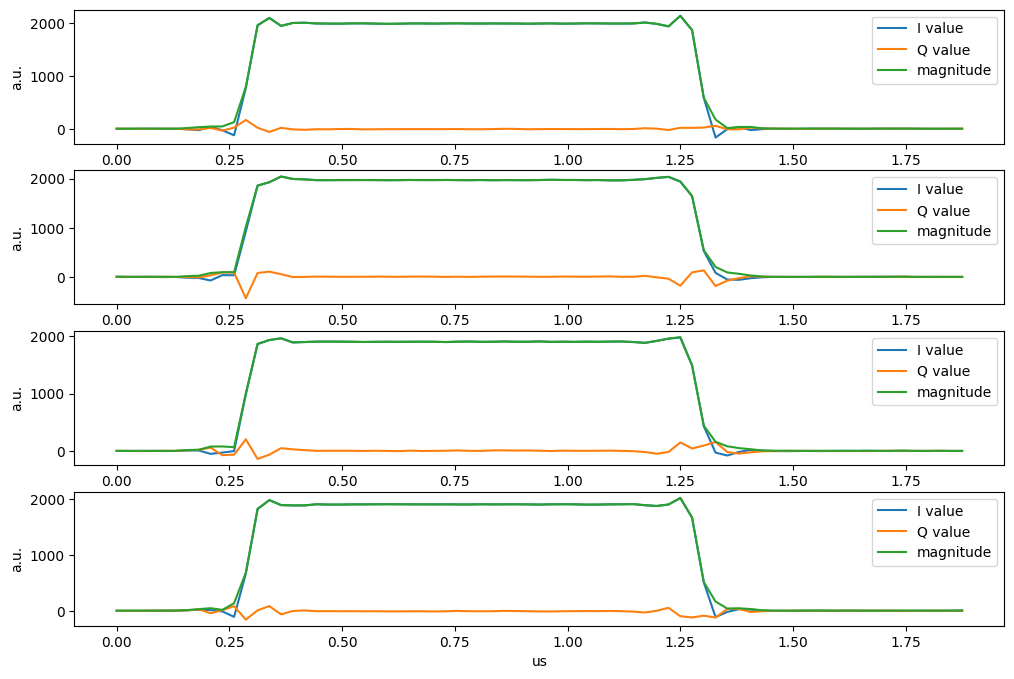

In [7]:
config = {'gen_ch': 1,
          'ro_chs': [2,3,4,5],
          'pulse_freqs': [500, 550, 600, 650],
          'pulse_gains': [1.0]*4,
          'pulse_phases': [-x for x in phases],
          'ro_phases': [0.0]*4,
          'trig_time': 0.4,
          'pulse_len': 1.0,
          'ro_len': 1.9,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,8))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

  0%|          | 0/1 [00:00<?, ?it/s]

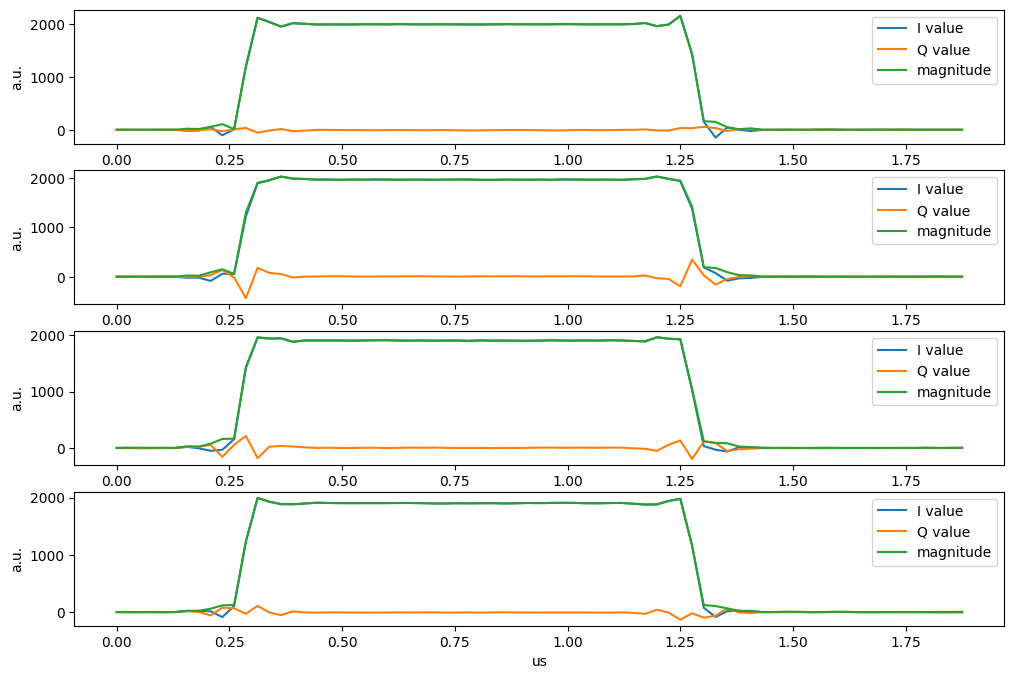

In [8]:
config = {'gen_ch': 1,
          'ro_chs': [2,3,4,5],
          'pulse_freqs': [500, 550, 600, 650],
          'pulse_gains': [1.0]*4,
          'pulse_phases': [0.0]*4,
          'ro_phases': phases,
          'trig_time': 0.4,
          'pulse_len': 1.0,
          'ro_len': 1.9,
         }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,8))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

## interpolated generator and standard (PYNQ-configured) readout (almost identical to 00_intro)
The only difference between this program and the one in the 00_intro notebook is that you need to set the mixer frequency.

If you've used the interpolated generator in tProc v1, it's the same here. Remember that the digital LO is not phase-coherent with respect to frequency changes (see e.g. https://github.com/openquantumhardware/qick/issues/122). Also, a very verbose reminder of how the readout frequency is defined when you're using the digital mixer:

### frequency-matching and the digital mixer
This has nothing to do with tProc v2, but I needed to write this stuff somewhere.

Remember that if your generator has a digital mixer and you set a nonzero `mixer_freq`, the software will add this mixer frequency to whatever readout downconversion frequency you specify.
To be precise (and assuming you requested frequency-matching - i.e. your generator declaration, your readout declaration, and your pulse definition all reference the matched channel):
* The mixer frequency is rounded to a common multiple of the mixer and readout frequency step sizes.
* The pulse frequency is rounded to a common multiple of the generator and readout frequency step sizes.
* The readout frequency you request is rounded to a common multiple of the generator and readout frequency step sizes (the generator step size is always a multiple of the corresponding mixer's step size). Then this is added to the rounded mixer frequency, and the sum is what actually gets used for downconversion - similar to what would happen if there were also a digital mixer on the readout side.

This behavior sometimes leads to confusion:
* If you (as an experienced experimentalist) expect simple, literal "do what I asked for, not what I meant" behavior from your instruments, and you know there is no digital mixer on the readout side, you will expect your downconversion frequency to just be what you requested, and then nothing will work.
* Conversely, you might see this behavior and conclude that there is a digital mixer on both sides, maybe fed from a common oscillator, and this might lead you astray in debugging some other problem you are having.

But this behavior exists to ensure proper frequency matching. Consider this toy example with easy but fake numbers:
* Let's say all three frequencies in your system (your generator's carrier and mixer frequencies, and your readout's downconversion frequency) all have step sizes of 1 MHz.
* Let's say you (reasonably) pick your frequencies without thinking about the frequency quantization. You want a 100.3 MHz mixer frequency and a 100.3 MHz carrier frequency.
* So you would set the mixer frequency to 100.3, and use 100.3 in both the pulse and readout definitions. All three numbers will be rounded, so you will end up with:
    * Mixer at 100 MHz, carrier at 100 MHz, the digital mixer will add those and your signal will go out at 100+100 = 200 MHz.
    * The software will configure the readout at the sum of the two post-rounding values, so 100+100 = 200 MHz. Frequencies are matched and your readout will work.
* Let's suppose the software didn't add the mixer_freq to your readout frequency. So you would use 100.3 MHz for the mixer and pulse, and you will do your own math to figure out that the readout should be at 100.3+100.3 = 200.6 MHz. The result:
    * As before, mixer at 100 MHz, carrier at 100 MHz, signal will go out at 200 MHz
    * The software will round your 200.6 MHz and configure your readout at 201 MHz. You will get a frequency mismatch!

In [9]:
class SimpleSweepProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, ro_ch=ro_ch, mixer_freq=cfg['mixer_freq'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/5, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/1 [00:00<?, ?it/s]

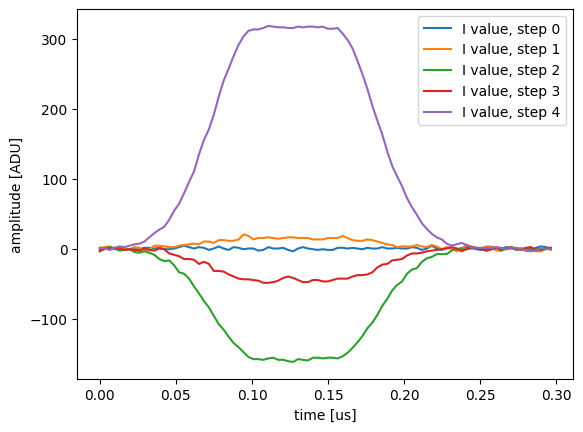

In [10]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 2,
          'ro_ch': 0,
          'freq': 500,
          'mixer_freq': 1500,
          'trig_time': 0.45,
          'ro_len': 0.3,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("myloop", -360, 720),
          'gain': QickSweep1D("myloop", 0.0, 1.0)
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

## standard (full-speed) gen and tProc-configured readout

If you've used the tProc-configured readout in tProc v1, it's the same here:

The tProc-configured readout (readout_v3) was designed as a phase-resettable readout for applications (e.g. the three-wave mixing readout in https://arxiv.org/abs/2311.17171, or the laser stabilization in https://github.com/openquantumhardware/qick/issues/120) where you need to phase-reset the generator that's playing your readout tone, and therefore need to simultaneously reset the readout phase. **This demo firmware does not actually synchronize the gen and readout resets, as you would need in that scenario.** This demo showcases the other useful feature of this readout, which is that you can sweep the downconversion frequency inside your QICK program.

Anyway, the point is that this readout gets its configuration parameters (downconversion frequency, output selection, etc.) through a tProc interface, in the same way that the standard generator gets pulse parameters from the tProc. So this is how you use it:
1. Use `add_readoutconfig()` (similar to `add_pulse()`) to define a "readout config" in your program that is a lot like a pulse (it's stored as a waveform, it can be swept).
2. At some point in your program, use `send_readoutconfig()` (similar to `pulse()`) to send the config to the readout. Make sure this reaches your readout before the signal does.

Don't forget to do both steps! Your readout is not going to magically see the readout config just because you defined it. Nor will it get sweep updates - if you sweep a readout parameter, you need to send the config to your readout at each sweep step (typically you can just do this at start-of-shot).

By the way - for the other ("PYNQ-configured") readouts, you put your readout parameters in declare_readout(). Those parameters do not go in the assembly code; they are written directly to the readout block (through the PYNQ interface) before the program is executed, and you can't change those parameters while your program is running. You can make an analogy to the mux generator's frequency+gain parameters (which are set through PYNQ).

### a little note about how/why this readout is weirder than necessary
Note that the requirement for a phase reset that can be synchronized with a full-speed generator makes this readout a little weird:
* Compared to the other readouts, it's relatively annoying to put this one in a firmware.
* It only downsamples the ADC by 4 as opposed to 8. This improves your time resolution but raises the cutoff of the decimation filter.
    * You probably don't care about the time resolution.
    * You may care about the decimation cutoff, because you rely on that filter to kill the image tone described in https://github.com/openquantumhardware/qick/blob/main/qick_demos/08_Special_buffers.ipynb. In other words, you need more separation between your readout tone and the ADC's Nyquist zone boundaries: roughly fs/16 instead of fs/32 (https://github.com/openquantumhardware/qick/issues/120#issuecomment-1494931618).
 
If there is big demand for a sweepable readout that isn't weird but doesn't have a synchronized phase-reset, it's doable - let us know. (Technically you could still sync the phase-reset, but with a requirement of fs\_DAC = 2\*fs\_ADC as opposed to fs\_DAC = 4\*fs\_ADC, and most people want their DACs to be faster than that.)

### basic loopback
Here the readout parameters aren't swept, so we can both define them and set them in `initialize()`.

Note that I put definitions (these add stuff to the program metadata - generally they start with "add" or "declare") before the tProc instructions (these add ASM instructions to the program, which are executed by the tProc) in `initialize()`. This isn't a rule, but it's good code hygiene to sort of separate the "setup" stuff from the code that actually runs as part of your experiment sequence. (As an example of what not to do? You can put definitions in the `body()` and your program will work fine! Definitions do their thing when the Python interpreter sees them during compilation, so your tProc loops have no effect on them. But it will look very strange.)

In [11]:
class SimpleSweepProgram2(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/5, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/1 [00:00<?, ?it/s]

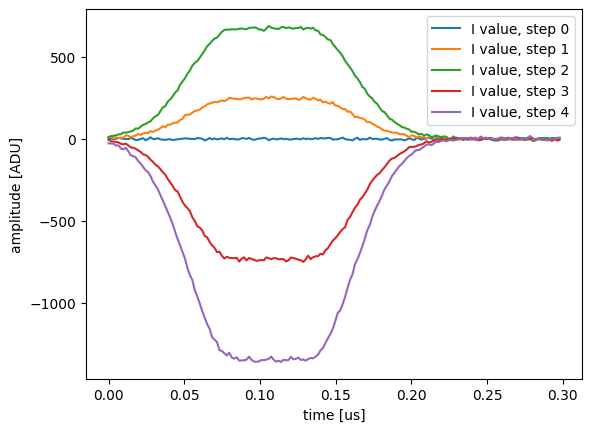

In [12]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 0,
          'ro_ch': 1,
          'freq': 1500,
          'nqz': 1,
          'trig_time': 0.35,
          'ro_len': 0.3,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("myloop", -360, 720),
          'gain': QickSweep1D("myloop", 0.0, 1.0)
         }

prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");


### frequency sweeping
Now we'll sweep the upconversion and downconversion frequencies together. Note that we therefore need to put `send_readoutconfig()` in the `body()`.

We'll start with a small frequency range.

  0%|          | 0/10 [00:00<?, ?it/s]

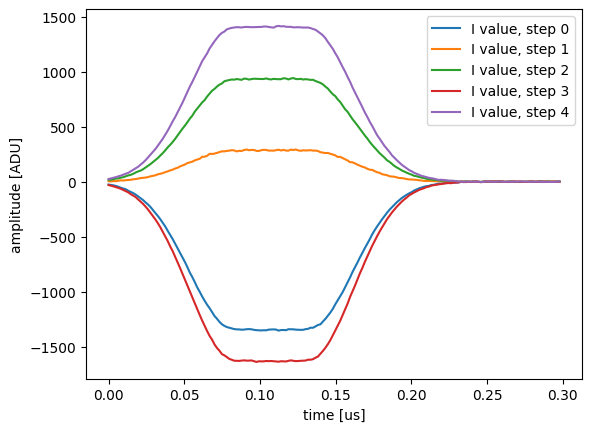

In [13]:
START_FREQ = 1500
CAL_RANGE = 1
END_FREQ = 8000

class FreqSweepProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/5, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 0,
          'ro_ch': 1,
          'freq': QickSweep1D("myloop", START_FREQ, START_FREQ+CAL_RANGE),
          'nqz': 1,
          'trig_time': 0.35,
          'ro_len': 0.3,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

Now let's do small steps. As you know from the "phase coherence" demo (demo 01 in qick_demos), frequency sweeps give you a rotating phase because the upconversion and downconversion LOs have different start times.

  0%|          | 0/1000010 [00:00<?, ?it/s]

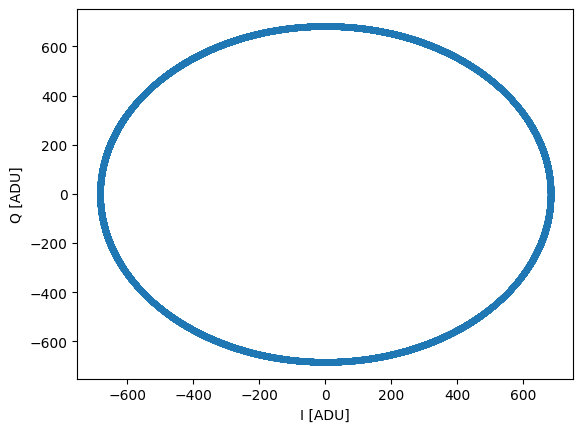

In [14]:
config['steps']=100001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
plt.ylabel("Q [ADU]")
plt.xlabel("I [ADU]");

We can plot the phase vs. frequency. Note that because our sweep steps are very small, and the sweep step needs to be rounded to the frequency-matching step size, the sweep range is noticeably different from what we asked for. (If this was a problem, you could adjust the step count to bring your nominal step size closer to the rounded value.)

Anyway, the phase difference between consecutive points is very small, which gives us confidence that we're measuring the phase rotation correctly and not getting something aliased.

phase step (cycles): -4.9997313085969886e-05


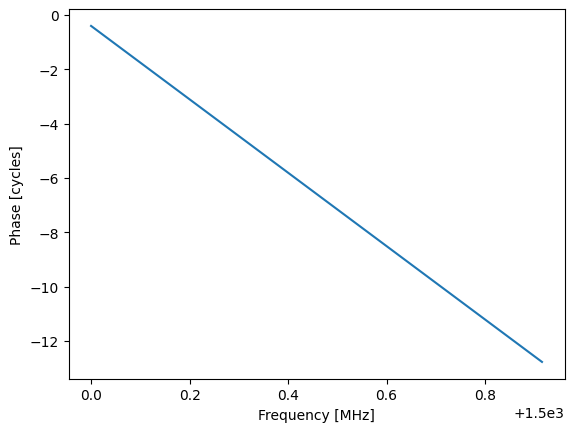

In [15]:
iq_complex = iq_list[0][0].dot([1,1j])
phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)

plt.plot(freqs, phases)
plt.ylabel("Phase [cycles]")
plt.xlabel("Frequency [MHz]")

print("phase step (cycles):", phases[1]-phases[0])

We can do a linear least-squares fit to get the slope, which we can interpret as a delay. (Your VNA would call this an "electrical delay" calibration.)

In [16]:
a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
print("relative delay %.4f us"%(phase_delay))

relative delay -13.5107 us


Now let's do a wide-range sweep and use the calibration to remove the phase delay.

  0%|          | 0/1000100 [00:00<?, ?it/s]

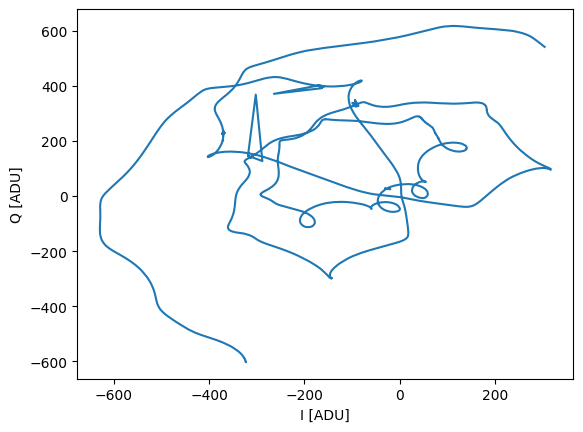

In [17]:
config['freq'] = QickSweep1D("myloop", START_FREQ, END_FREQ)
config['steps'] = 10001
# freqs = np.linspace(START_FREQ, END_FREQ, config['steps'])

prog = FreqSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])


iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*phase_delay)
plt.plot(np.real(iq_rotated), np.imag(iq_rotated))
plt.ylabel("Q [ADU]")
plt.xlabel("I [ADU]");

Plot the amplitude and phase: we can see the resonator at 2.8 GHz as a dip in magnitude and a pi rotation in the phase.

By the way - notice that the spectrum is mirrored around 4.9 GHz. This happens because the DAC sampling frequency is 4 times that of the ADC, and 4.9 GHz is a Nyquist zone boundary for both. (The old ZCU111 standard firmware also had this property; the DAC sampling frequency was double that of the ADC.) In general, DACs and ADCs cannot distinguish between Nyquist images (that's essentially the definition of a Nyquist zone). So:
* Whether you ask the generator to play 4.9-x or 4.9+x, the DAC will play both. Whether you ask the readout to downconvert at 4.9-x or 4.9+x, it will be sensitive to both. The first tone is in the DAC's 1st Nyquist zone and the ADC's 4th/3rd/2nd/1st Nyquist zone, the second is in the DAC's 2nd Nyquist zone and the ADC's 5th/6th/7th/8th.
* The transmission value you measure will be the sum of the two tones.
* Filtering (the DAC's `nqz` setting, the analog response of the DAC and ADC, the balun response, and any other analog filtering) changes the relative strength and transmission of the two tones. Here the resonance is in a region where the `nqz` setting, analog response, and balun response strongly favor the 2.8 GHz tone over the 7 GHz tone, so we mostly just see the 2.8 GHz response. Were that not the case, the resonance would be largely washed out by transmission at the other tone.

More generally, in a serious measurement you always want to filter, even if your firmware does not have this simple-multiples relation between DAC and ADC sampling frequencies:
* Filter your DAC to remove any unwanted Nyquist images which could otherwise saturate your amplifiers, create spurs in your mixers, and do weird things to your device.
* Filter your ADC to ensure that it sees your measurement tone but is blind to the noise at any of its Nyquist images.
* If your operating frequency is close to a DAC or ADC Nyquist boundary, it's going to be very difficult to filter appropriately. You should consider changing the sampling frequency (this requires recompiling the firmware).

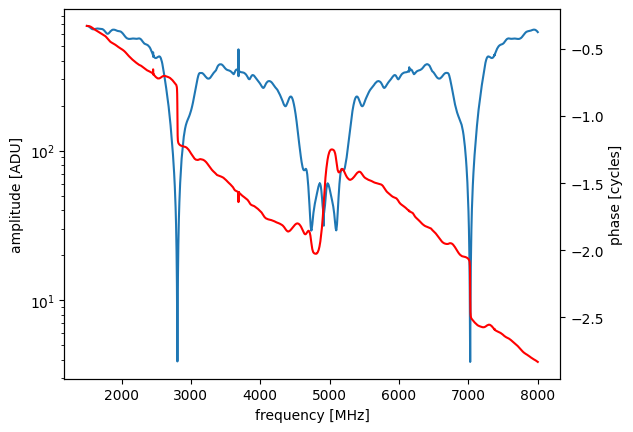

In [18]:
phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(iq_rotated), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylabel("amplitude [ADU]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

Note that instead of correcting the phase of the data, you could use a phase sweep in the pulse or the readout config. There's no obvious advantage in this case (or ever?), so it's left as an exercise for the reader.

## extra: readout IQ offsets

Some of the readout blocks (not the standard one, but basically everything else) put small nonzero offsets on the I and Q values. For example, the muxed readouts give you I and Q centered around -0.5 in the absence of a signal. This is an artifact of how the ADC values get truncated. If you don't correct for this effect, it shows up in strange ways, usually as a oscillating amplitude vs. freq for very small signals: your signal is small, it rotates in the IQ plane as your frequency changes, the offset is always (-0.5, -0.5) so the offset will sometimes add to your signal and sometimes subtract.

Anyway, we very recently (https://github.com/openquantumhardware/qick/pull/254) added a software workaround for this - `acquire()` and `acquire_decimated()` will subtract out the offsets. The raw data arrays are not subtracted, and if you do feedback your tProc input will also see the raw value without subtraction.

Here are two simple programs that do long readouts with no pulse playing, to measure the offsets in the raw data (and you can see that the output of `acquire()` doesn't have the offset).

  0%|          | 0/1000 [00:00<?, ?it/s]

IQ offsets: [array([[ 4.83723958e-05, -3.98470052e-04]]), array([[0.02325391, 0.02470859]]), array([[0.02325391, 0.02470859]]), array([[0.02324896, 0.02471979]]), array([[0.02324896, 0.02471979]])]


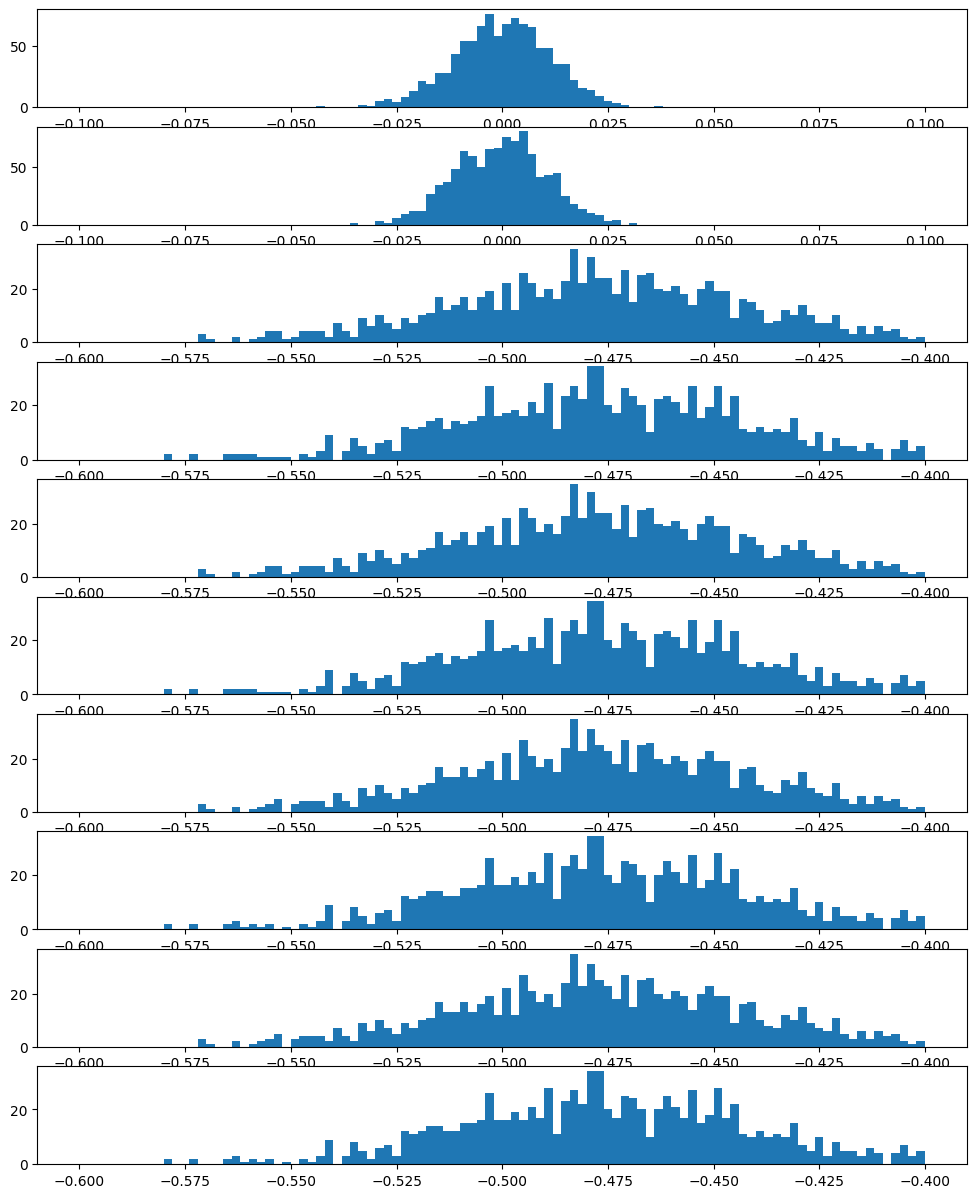

In [19]:
class TestProgram(AveragerProgramV2):
    def initialize(self, cfg):
        for ch in cfg['ro_chs']:
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=100)

    def body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], t=0.0)
        
config = {
    'ro_chs': [0,2,3,4,5],
    'ro_len': 100.0,
 }

prog = TestProgram(soccfg, reps=1000, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc, soft_avgs=1)
print("IQ offsets:", iq_list)

iq_raw = prog.get_raw()

nch = len(prog.ro_chs)
fig, axes = plt.subplots(2*nch, 1, figsize=(12,3*nch))
for i, (ch, rocfg) in enumerate(prog.ro_chs.items()):
    
    offset = soccfg['readouts'][ch]['iq_offset']
    bins = np.linspace(offset-0.1, offset+0.1, 101)
    nsamp = rocfg['length']
    plot = axes[2*i]
    plot.hist(iq_raw[i][:,0,0]/nsamp, bins=bins);
    plot = axes[2*i+1]
    plot.hist(iq_raw[i][:,0,1]/nsamp, bins=bins);

  0%|          | 0/1000 [00:00<?, ?it/s]

[array([[-0.01684033, -0.01532443]])]


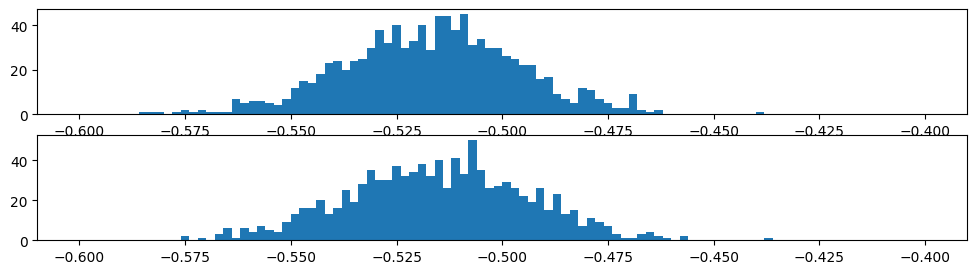

In [20]:
class TestProgram2(AveragerProgramV2):
    def initialize(self, cfg):
        for ch in cfg['ro_chs']:
            confname = "myro%d" % (ch)
            self.declare_readout(ch=ch, length=cfg['ro_len'])
    
            self.add_readoutconfig(ch=ch, name=confname, freq=100)
            self.send_readoutconfig(ch=ch, name=confname, t=0)
        
    def body(self, cfg):
        self.trigger(ros=cfg['ro_chs'],  t=0)

config = {
    'ro_chs': [1],
    'ro_len': 100.0,
 }

prog = TestProgram2(soccfg, reps=1000, final_delay=0.5, cfg=config)

iq_list = prog.acquire(soc, soft_avgs=1)
print(iq_list)

iq_raw = prog.get_raw()

nch = len(prog.ro_chs)
fig, axes = plt.subplots(2*nch, 1, figsize=(12,3*nch))
for i, (ch, rocfg) in enumerate(prog.ro_chs.items()):
    
    offset = soccfg['readouts'][ch]['iq_offset']
    bins = np.linspace(offset-0.1, offset+0.1, 101)
    nsamp = rocfg['length']
    plot = axes[2*i]
    plot.hist(iq_raw[i][:,0,0]/nsamp, bins=bins);
    plot = axes[2*i+1]
    plot.hist(iq_raw[i][:,0,1]/nsamp, bins=bins);